In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp #used to form equation and solve it
from pprint import pprint
from sklearn.manifold import MDS
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D
import math

# Phase #1

## Loading the Data

In [73]:
# Load the Iris dataset
iris = load_iris()

# Access the features (X) and target (y) variables
x_iris = iris.data
y_iris = iris.target

## Define PCA from Scratch

In [74]:
class Custom_PCA():
  mean = None
  q_matrix = None
  n_components = 0
  normalize=None

  def _compute_eigen_values(self,cov_matrix,show_info):
    # Define the symbolic variable & diagonal matrix
    lambda_sym = sp.symbols('lambda')
    diagonal_matrix = sp.diag(*([lambda_sym] * len(cov_matrix)))

    # Define the matrix
    matrix = sp.Matrix(cov_matrix)
    matrix = matrix-diagonal_matrix

    # Find the characteristic equation by computing the determinant
    characteristic_equation = sp.det(matrix)

    # Solve for lambda in the characteristic equation
    eigen_values = sp.solve(characteristic_equation, lambda_sym)

    # Round eigen values after turning it to float
    eigen_values = [float(eigen_value) for eigen_value in eigen_values]
    eigen_values = np.round(eigen_values, decimals=6)

    if show_info:
    # Print the characteristic equation and solutions
      print("Characteristic Equation:")
      sp.pprint(characteristic_equation)

      print("\nSolutions for lambda:")
      print(eigen_values)
    return eigen_values


  def _compute_eigen_vector(self,cov_matrix,eigen_values):
    zero_matrix = np.zeros(len(cov_matrix))
    eigen_vectors = None
    for eigen_value in eigen_values:
      # make copy of cov_matrix
      new_cov_matrix = np.copy(cov_matrix)
      # update diagonal
      for i in range(len(cov_matrix)):
        new_cov_matrix[i,i] =  new_cov_matrix[i,i] - eigen_value
      # solving the homogeneous equations system (using pseudo inverse to solve singular matrix like one in lab)
      _, _, V = np.linalg.svd(new_cov_matrix, full_matrices=True)
      eigen_vector = V[-1]
      # append results
      if eigen_vectors is None:
        eigen_vectors = eigen_vector
      else:
        eigen_vectors = np.column_stack((eigen_vectors,eigen_vector))

    # normailzae the data
    eigen_vectors = eigen_vectors/np.linalg.norm(eigen_vectors, axis=0)
    return eigen_vectors


  def fit(self, data,show_info = False):
    # Step 1: Compute mean vector.
    self.mean = np.mean(data,axis=0)

    # Step 2: Compute the covariance matrix.
    shiftted_mean = data-self.mean
    cov_matrix = np.dot(shiftted_mean.T,shiftted_mean)/data.shape[0]

    # Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix. using |C-λI|=0
    # Compute Eigen Values
    eigen_values = self._compute_eigen_values(cov_matrix,show_info)
    # Sort absolute Eigen Values to get sorted eigen vectos
    new_indices = np.argsort(np.abs(eigen_values))[::-1]
    eigen_values = eigen_values[new_indices]
    # Compute Eigen Vecotr
    eigen_vectors = self._compute_eigen_vector(cov_matrix,eigen_values)

    # Step 4: Compute a matrix Q using normalized eigenvectors sorted by absolute eigenvalues.
    self.q_matrix = eigen_vectors.T

  def transform(self, data, n_components):
    # Step 5: Transform the original matrix [ F`= Q (F-m)]
    self.n_components = n_components
    components = self.q_matrix[:self.n_components,: ]
    return np.dot(components,(data-self.mean).T) # component*features x features*samples = component*samples


  def inverse_transform(self, projec_data):
    inverse_data = np.dot(self.q_matrix[:self.n_components,:].T, projec_data) # features*component * component*samples = n*n
    return (inverse_data+self.mean[:,np.newaxis]).T

## Apply PCA on Sample Code (Without Normalization)

### Random Example

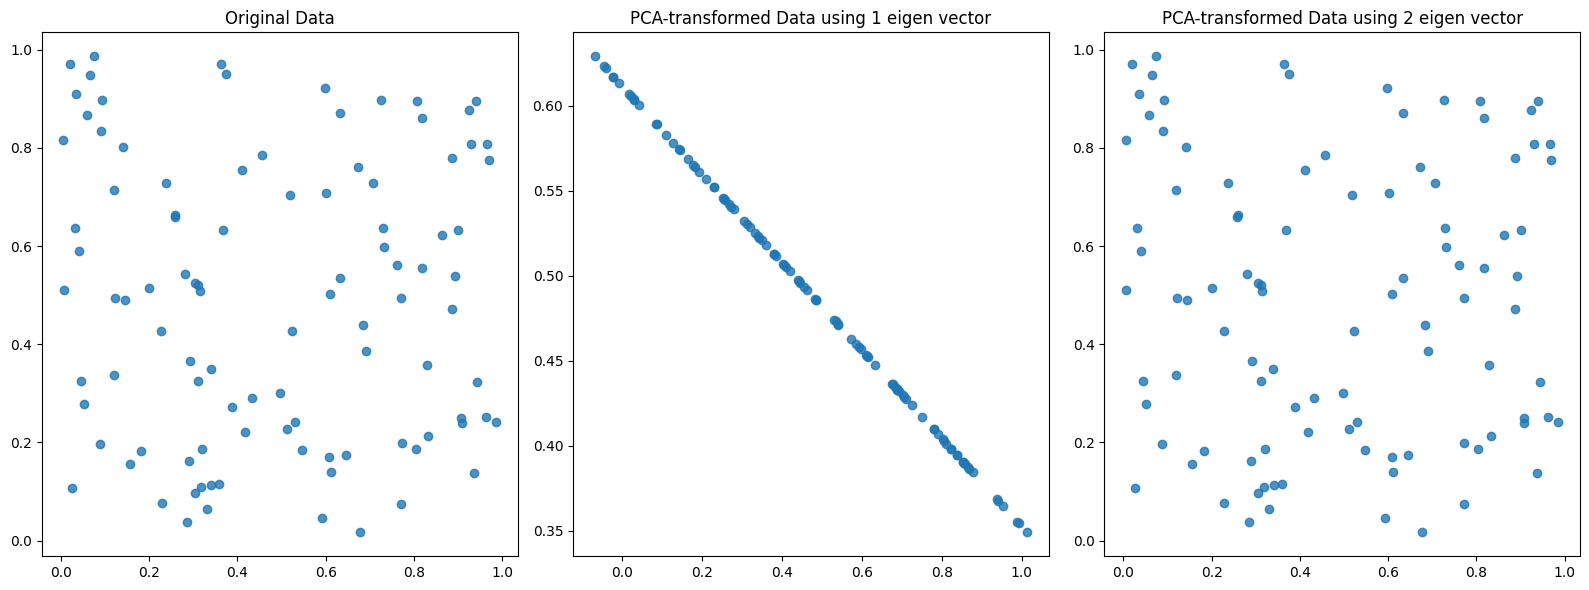

In [75]:
# Create a sample dataset
np.random.seed(42)
random_sample = np.random.rand(100, 2)  # 100 samples, 2 features

# Apply PCA
pca = Custom_PCA()
pca.fit(random_sample,False)
X_pca = pca.transform(random_sample,1)
X_pca = pca.inverse_transform(X_pca)

# Plot the original and PCA-transformed data
plt.figure(figsize=(16, 6))

# Original data
plt.subplot(1, 3, 1)
plt.scatter(random_sample[:, 0], random_sample[:, 1], alpha=0.8)
plt.title('Original Data')

# PCA-transformed data
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)
plt.title('PCA-transformed Data using 1 eigen vector')

# PCA-transformed data
X_pca = pca.transform(random_sample,2)
X_pca = pca.inverse_transform(X_pca)

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)
plt.title('PCA-transformed Data using 2 eigen vector')

plt.tight_layout()
plt.show()


## Using different Q Matrix

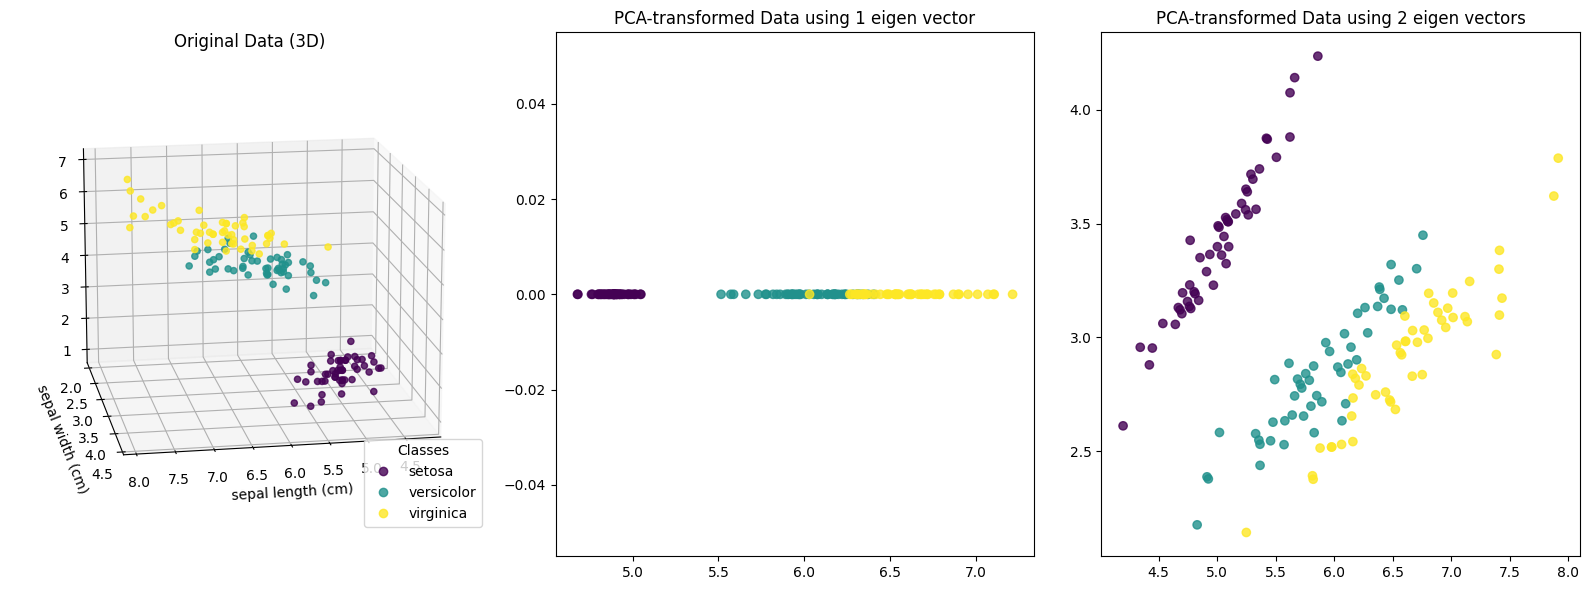

In [76]:
# Apply PCA
pca = Custom_PCA()
pca.fit(x_iris, False)

# Plot the original and PCA-transformed data
fig = plt.figure(figsize=(16, 6))

# Original data in 3D with color based on y_iris
ax1 = fig.add_subplot(1, 3, 1, projection='3d',elev=15, azim=80)
scatter = ax1.scatter(x_iris[:, 0], x_iris[:, 1], x_iris[:, 2], c=y_iris, cmap='viridis', alpha=0.8)
ax1.set_title('Original Data (3D)')

# PCA-transformed data using 1 eigen vector with color based on y_iris
X_pca_1 = pca.transform(x_iris, 1)
X_pca_1 = pca.inverse_transform(X_pca_1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(X_pca_1[:, 0], np.zeros_like(X_pca_1[:, 0]), c=y_iris, cmap='viridis', alpha=0.8)
ax2.set_title('PCA-transformed Data using 1 eigen vector')

# PCA-transformed data using 2 eigen vectors with color based on y_iris
X_pca_2 = pca.transform(x_iris, 2)
X_pca_2 = pca.inverse_transform(X_pca_2)

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y_iris, cmap='viridis', alpha=0.8)
ax3.set_title('PCA-transformed Data using 2 eigen vectors')

ax1.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
ax1.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

plt.tight_layout()
plt.show()

#Phase #2

##Entropy Based Fuzzy Clustering

In [77]:
class Entropy():
    def __init__(self, data, target=None):
        self.data = data
        self.target = target
        self.distance_Matrix = self.construct_distance_matrix()
        self.alpha = self.get_alpha()
        # the fuzziness parameter β and controls the level of fuzziness of the algorithm and it's the similarity threshold
        self.beta = 0.5
        # used to check for outliers
        self.eta = 0.3
        self.similarity_matrix = self.construct_similarity_matrix()
        self.entropies = self.calculate_entropies()
        self.clusters, self.centroids = self.create_clusters()
        self.render()



    def render(self):
        print(self.data)
        print(self.target if self.target is not None else "")
        self.plot_matrix(self.distance_Matrix)
        print(" ")
        pprint(self.clusters)
        self.check_outliers()
        self.get_centroids_points()
        self.plot_clusters()


    def plot_clusters(self):
        # Plot the data points and cluster centers
        plt.scatter(self.data[:, 0], self.data[:, 1], c=self.target, cmap='viridis', alpha=0.5)
        plt.scatter(np.array(self.centroids)[:, 0], np.array(self.centroids)[:, 1], c='red', marker='X', s=200)
        plt.title('Entropy Based Fuzzy Clustering')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

    def plot_matrix(self, matrix):
        plt.imshow(matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(label="Distance")
        plt.title('Distance Matrix')
        plt.xlabel('Data Points')
        plt.ylabel('Data Points')
        plt.show()
        print(" ")
        mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto') # works on dissimilarities
        mds = mds.fit_transform(matrix)
        plt.scatter(mds[:, 0], mds[:, 1])

        document_labels = ["P" + str(i+1) for i in range(matrix.shape[0])]
        for i, label in enumerate(document_labels):
            plt.annotate(label, (mds[i, 0], mds[i, 1]))
        plt.title("Distance")
        plt.show()

    def get_centroids_points(self):
        self.centroids = [self.data[i] for i in self.centroids]

    def construct_distance_matrix(self):
        distance_Matrix = np.zeros((self.data.shape[0],self.data.shape[0]))

        for i in range(distance_Matrix.shape[0]):
            for j in range(distance_Matrix.shape[0]):
                distance_Matrix[i][j] = np.sqrt(np.sum(np.square(self.data[i] - self.data[j])))
        return distance_Matrix


    def get_alpha(self):
        return math.log(2) / (np.sum(self.distance_Matrix) / (self.distance_Matrix.shape[0]**2 - self.distance_Matrix.shape[0])) # we subtract the the number of zeros in the matrix as they aren't needed to
                                                                                                                  # compute mean of distances


    def construct_similarity_matrix(self):
        similarity_matrix = np.exp(- self.alpha * self.distance_Matrix)
        return similarity_matrix


    def calculate_entropies(self):

        # Adding 10e-16 to avoid dividing by zero in log2
        entropies = - np.sum((self.similarity_matrix * np.log2(self.similarity_matrix + 10e-16)) + ((1 - self.similarity_matrix) * np.log2(1 - self.similarity_matrix + 10e-16)), axis=1)
        return entropies


    def create_clusters(self):
        clusters = {}               # dictionary for holding centroids and their neighbors
        centroids = []
        previous_included_points = []
        while len(previous_included_points) < len(self.entropies):
            ind_min_entropy = np.argmin(self.entropies)     # gets the index of the current minimum entropy

            centroids.append(ind_min_entropy)                 # append centroids

            similarity_for_entropy = self.similarity_matrix[ind_min_entropy]        # gets all the similarities of that index in the similarity matrix

            similarity_for_entropy[previous_included_points] = 0                    # set all the similarities of all previous included points to zeros to not include them again
                                                                                    # in other clusters

            included_points = similarity_for_entropy >=  self.beta                  # compares the similarities with the assumed beta

            # adds the maximum value of entropies to the included points' entropies to exclude them from being chosen again
            self.entropies[included_points] = np.max(self.entropies) + self.entropies[included_points]

            # adds the indexes of the included points to the current cluster
            included_points = np.where(np.isin(self.entropies, self.entropies[included_points]))[0]
            clusters["P"+str(ind_min_entropy)] =  included_points

            # adds the current included points to the previous included points
            previous_included_points.extend(included_points)

        return clusters, centroids

    def check_outliers(self):
        print("\n Outliers")
        for i in self.clusters.keys():
            print(f'The Cluster of centroid {i} is valid' if (len(self.clusters[i]) / self.data.shape[0]) > self.eta else f'The Cluster of centroid {i} is outlier')
            if len(self.clusters[i]) / self.data.shape[0] < self.eta:
                self.centroids.remove(int(i[1:]))



[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

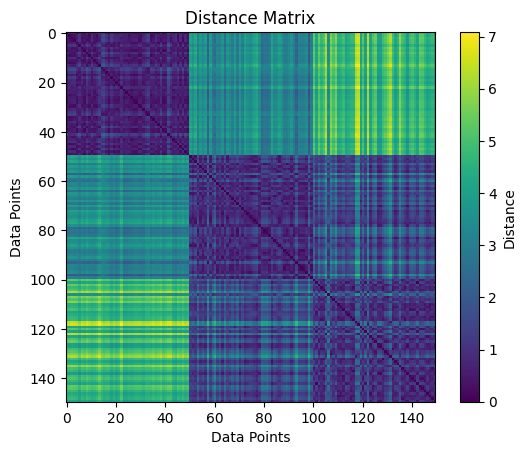

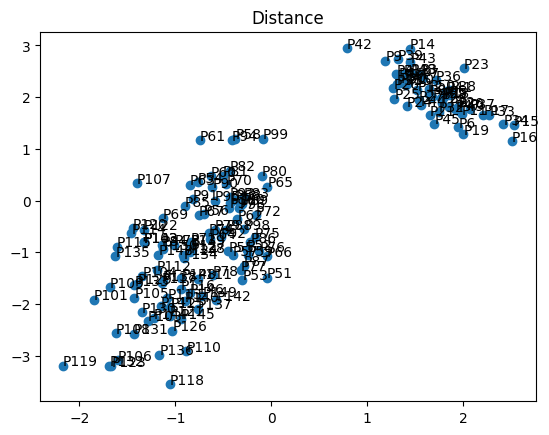

 
{'P0': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57,
       79, 93, 98]),
 'P147': array([ 50,  51,  52,  53,  54,  55,  56,  58,  59,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149]),
 'P60': array([60])}

 Outliers
The Cluster of centroid P0 is valid
The Cluster of centroid P147 is valid
The Cluster of centroid P60 is outlier


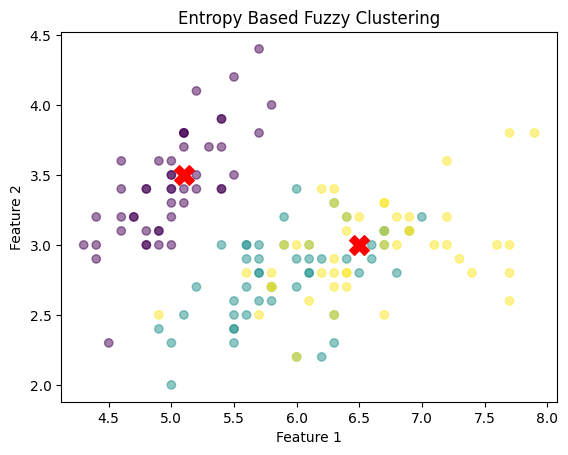

In [78]:
entropy = Entropy(x_iris, y_iris)

[[5.08303897 3.51741393 1.40321372 0.21353169]
 [4.7462619  3.15749994 1.46356177 0.24024592]
 [4.70411871 3.1956816  1.30821697 0.17518015]
 [4.6422117  3.05696697 1.46132981 0.23973218]
 [5.07175511 3.52655486 1.36373845 0.19699991]
 [5.50581049 3.79140823 1.67552816 0.32616959]
 [4.76528947 3.23041102 1.35723837 0.19551776]
 [5.00155648 3.39859911 1.47993231 0.2460815 ]
 [4.42052031 2.87903672 1.3855842  0.20882514]
 [4.80273233 3.20016781 1.48805402 0.2503016 ]
 [5.36090126 3.74023124 1.4985348  0.25243081]
 [4.90879014 3.28892521 1.51717562 0.26209953]
 [4.6820989  3.12115258 1.41198408 0.21884697]
 [4.34251794 2.95641673 1.08492393 0.08287986]
 [5.66151963 4.14156276 1.28795452 0.16277348]
 [5.85960752 4.23600886 1.48196707 0.24344301]
 [5.4275086  3.87100742 1.36995112 0.19816072]
 [5.09103106 3.50887425 1.43521594 0.22693854]
 [5.62144408 3.88058108 1.72215216 0.34527869]
 [5.24526768 3.65105838 1.4519108  0.23332171]
 [5.26539106 3.53834771 1.71102272 0.3420543 ]
 [5.20837272 

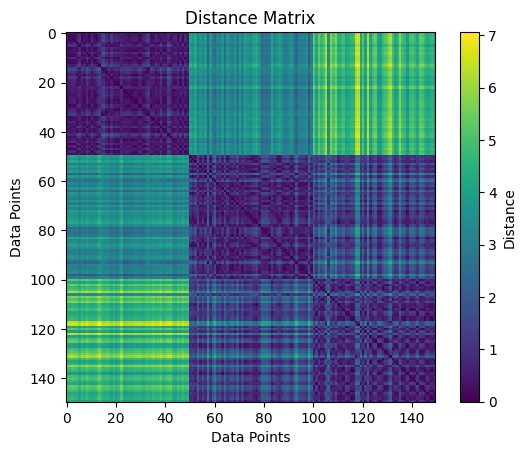

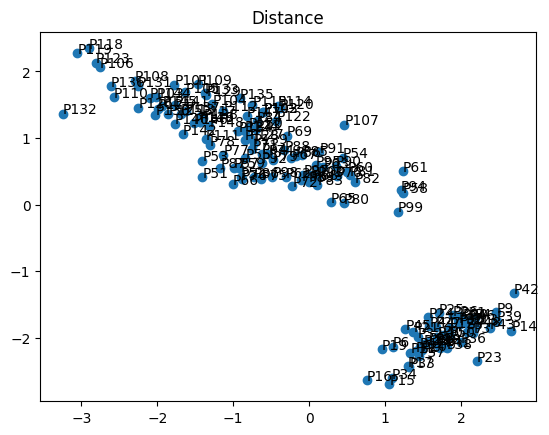

 
{'P117': array([117]),
 'P123': array([ 50,  51,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149]),
 'P49': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57,
       79, 93, 98])}

 Outliers
The Cluster of centroid P49 is valid
The Cluster of centroid P123 is valid
The Cluster of centroid P117 is outlier


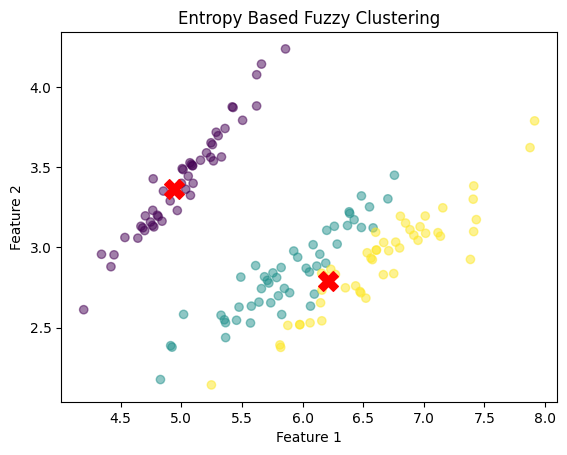

In [79]:
entropy = Entropy(X_pca_2, y_iris)

## Report
*   Using PCA with 2 dimensions helps to make data more separable compared to using most important feature which is sepal width and sepal height as shown in the picture.
*   Still some intersection of data which result from original plot between versicolor and virginica.

![iris data](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dataset_001.png)


###Effect of Using PCA:

* Clustering the original data led to the formation of two clusters, which aligns with logical expectations. This is due to the close proximity of the versicolor and virginica classes, as opposed to the setosa class.

*   Utilizing PCA with the optimal Q matrix containing two eigenvectors maintained two clusters observed in the original data case. However, the centroids and outlier instances differed from those in the original dataset.



